<a href="https://colab.research.google.com/github/sksvineeth/Text_and_clustering/blob/main/Detailed_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Netflix Case Study

Problem 1: Build Model(s)

· Group different movies using text and clustering algorithm.

In [38]:
# import libraries here; add more as necessary
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import nltk
import re
import string
import itertools
#nltk.download('punkt')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from collections import Counter

### **Data Cleaning :**

In [82]:
# Read data
np.random.seed(5)
data_first = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix_titles.csv')
data_first.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [84]:
data_first.groupby('type').count() # Subset only movies
data_first = data_first.loc[(data_first["type"] != 'TV Show')]

In [85]:
data_first.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...
6,s7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,"June 1, 2020",2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ..."


In [86]:
def convert(text):
    parts = text.split(' ')
    value = float(parts[0])
    return value

data_first['duration'] = data_first['duration'].apply(convert)

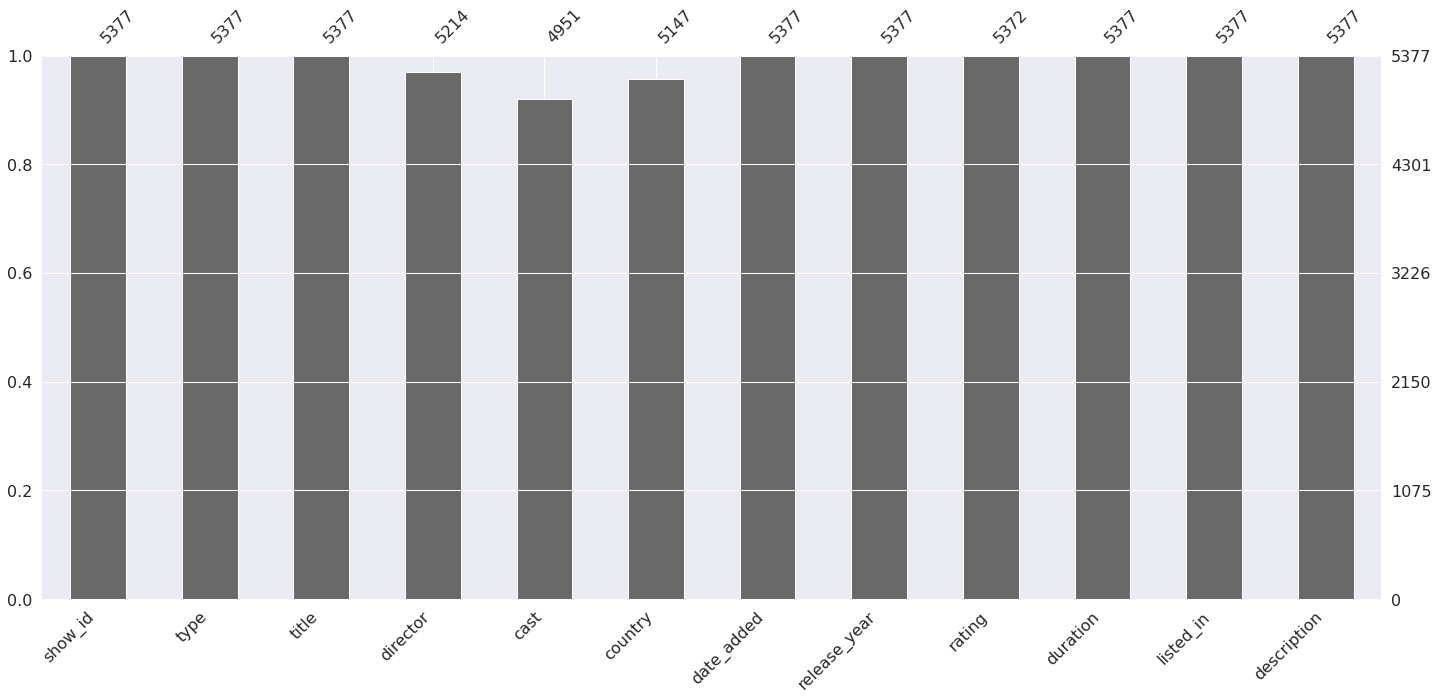

In [87]:
# Data Features - Multiple values - liste_in, Cast
#                - Categories - Rating, director
#Let's visualize and clean the data
missingno.bar(data_first);

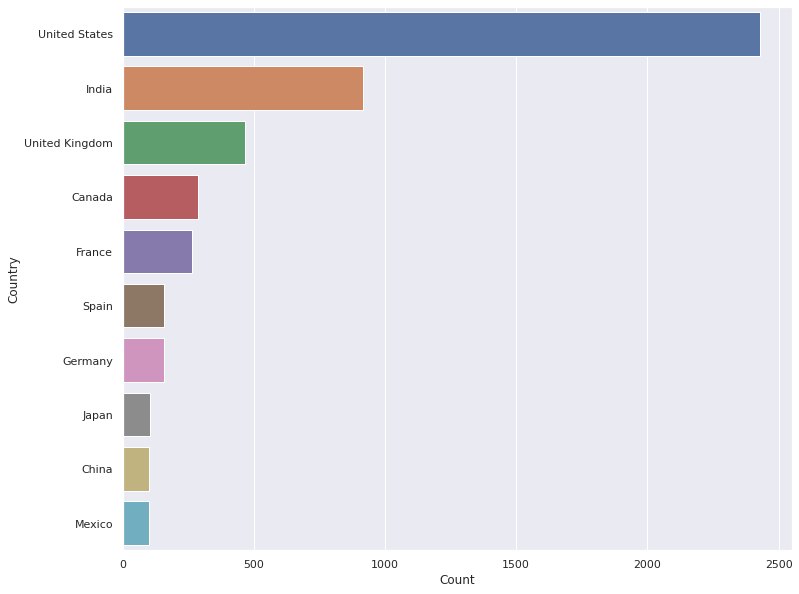

In [88]:
# Lets visualize data to decide the features.


list_country = [x.split(', ') for x in data_first.dropna(subset=['country'])['country'].tolist()]
list_country = list(itertools.chain(*list_country))
df_netflix_country_count = pd.DataFrame(Counter(list_country).most_common()[:10], columns=['Country', 'Count'])

plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.barplot(y="Country", x='Count', data=df_netflix_country_count, orient='h')

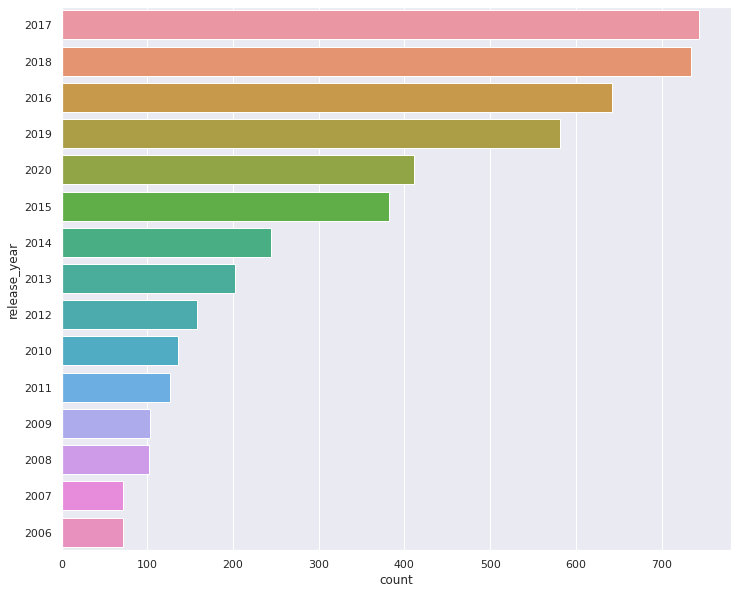

In [17]:
#Year

plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y='release_year', data=data_first, order=data['release_year'].value_counts().index[0:15])

In [89]:
# Cleaning and one hot encoding categorical variables

def clean(column_name):
    """This function takes a column from the dataframe and splits two elements
       if they are separated by a comma.
       For ex. in Actors column there might be values such as Christian Bale, Morgan Freeman.
       This will separate these two actors and store them individually in a list."""
    name=set()
    for name_string in data_first[column_name]:
        name.update(name_string.split(', '))
    name=sorted(name)
    return name

def top(column_name):
    """This function takes its input as name of the column and returns a sorted list of the 
       elements which occur very frequently in that column in descending order."""
    
    name=clean(column_name)
    dummy_name=pd.DataFrame()
    for n in name:
        dummy_name[n]=[int(n in nm.split(', ')) for nm in data_first[column_name]] 
    
    namelist=[n for n in name]
    nlt=dummy_name[namelist].sum()
    nlt=nlt.sort_values(axis=0,ascending=False)
    return nlt.index
    
def plot_column(column_name,n_elem_display=0):
    """ This function is used to plot a bar graph of a column of the dataframe.
        It takes its argument as name of column and number of elements to display and
        return a bar graph of the user defined number of top elements which occur
        frequently in that column."""
    
    name=clean(column_name)
    dummy_name=pd.DataFrame()
    for n in name:
        dummy_name[n]=[int(n in nm.split(', ')) for nm in data_first[column_name]] 
    
    namelist=[n for n in name]
    nlt=dummy_name[namelist].sum()
    nlt=nlt.sort_values(axis=0,ascending=False)
    if n_elem_display !=0:
        return nlt[:n_elem_display].plot(kind = "bar",figsize=(10,10))
    else:
        return nlt[:].plot(kind = "bar",figsize=(10,5))

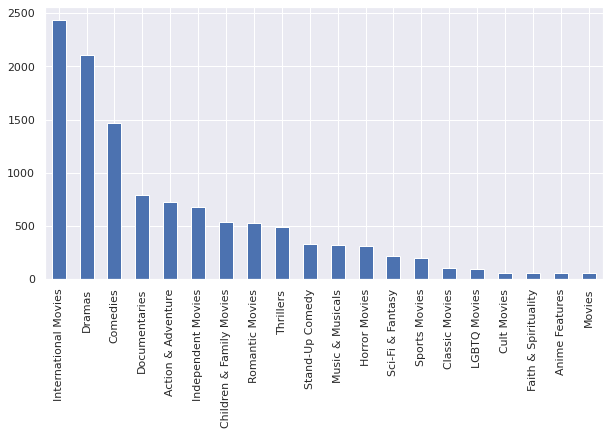

In [91]:
plot_column('listed_in')
#Get the unique genres contained in the dataframe
genres= clean('listed_in')
#Add one column for every genre in the dataframe
for genre in genres:
    data_first["genre:"+genre] = [int(genre in g.split(', ')) for g in data_first.listed_in]

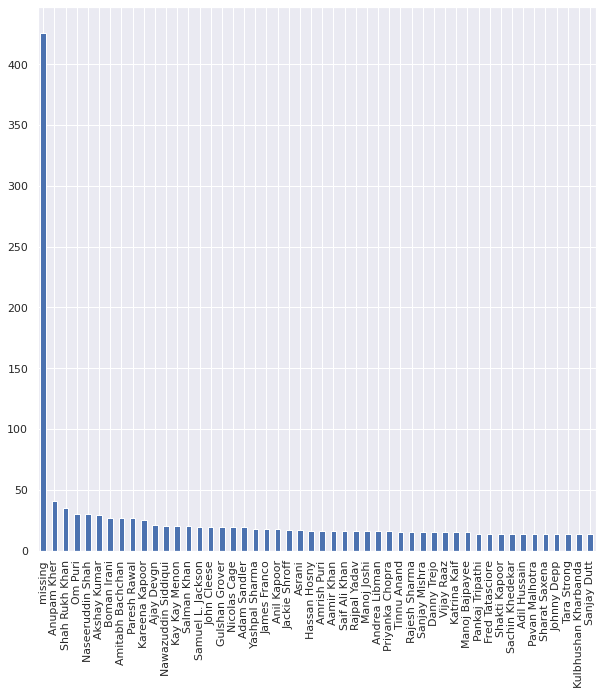

In [93]:
#data_first = data_first.fillna('missing')
plot_column('cast', 50)
#Get the unique actors contained in the dataframe
Actors= top('cast')
#Add one column for every actor in the dataframe
for Actor in Actors[:50]: #checked different ranges and fixed for 50
    data_first["Cast:"+ Actor] = [int(Actor in g.split(', ')) for g in data_first.cast]

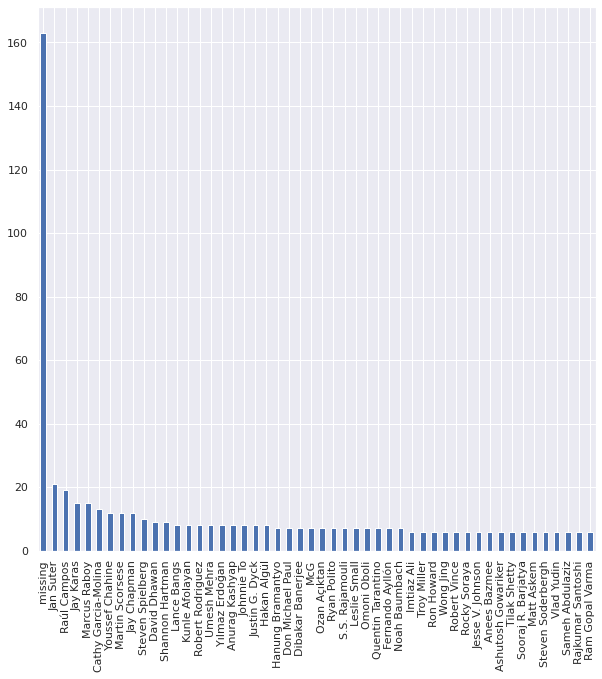

In [26]:
plot_column('director', 50)
directors=top('director')
    
for director in directors[:50]:
    data_first["Director:"+director] = [int(director in d.split(', ')) for d in data_first.director]

In [49]:
data_first.shape

(5377, 132)

### **Text processing**

In [50]:
def my_analyzer(s):
# Synonym List
    syns = {'wont':'would not', 'cant':'can not', 'cannot':'can not', \
    'couldnt':'could not', 'shouldnt':'should not', \
    'wouldnt':'would not', 'straightforward': 'straight forward' }
    # Preprocess String s
    s = s.lower()
    #Replace special characters with spaces
    s = s.replace('-', ' ')
    s = s.replace('_', ' ')
    s = s.replace(',', '. ')
    s = s.replace('\\',"")
    s = s.replace('.',"")

    # Replace not contraction with not
    s = s.replace("'nt", " not")
    s = s.replace("n't", " not")

    # Tokenize
    tokens = word_tokenize(s)

    #tokens = [word.replace(',','') for word in tokens ]

    tokens = [word for word in tokens if ('*' not in word) and \
    ("''" != word) and ("``" != word) and \
    (word!='description') and (word !='dtype') \
    and (word != 'object') and (word!="'s")]

    # Map synonyms
    for i in range(len(tokens)):
        if tokens[i] in syns:
            tokens[i] = syns[tokens[i]]

    # Remove stop words
    punctuation = list(string.punctuation)+['..', '...']
    pronouns = ['i', 'he', 'she', 'it', 'him', 'they', 'we', 'us', 'them','he ']
    others = ["'d", "co", "ed", "put", "say", "get", "can", "become",\
            "los", "sta", "la", "use","ask" "iii", "else","doesn't","dr.","well","let","soon","finally","around","little",\
              "would","set","use","place","still","three","arrive","next","anoth","keep","must","mr.","bring",\
              "much","many","eventually","explain","asks","along","may","small","hold","realize","think","continue",\
             "last","behind","discover","something","several","end","large","high","mr","the","dr","mr"]
    names = ["harry","travis","tommy","joe","jack","dorothy","mike","george","frank","frankie",\
            "frank ","sarah","andrew","taylor","arthur","luke","kane","wallace","parker","danny","tony",\
            "michael","luke","kane","danny","john","max","tom","paul","ca","neil","maria","barry","anna","jerry",\
            "alex","terry","henry","gordon","leonard","wayne","vincent","jimmy","jordan","sam","nick","nicholson",\
            "jake","rocky"]

    stop = stopwords.words('english') + punctuation + pronouns + others + names
    filtered_terms = [word for word in tokens if (word not in stop) and \
    (len(word)>1) and (not word.replace('.','',1).isnumeric()) \
    and (not word.replace("'",'',2).isnumeric())]

    # Lemmatization & Stemming - Stemming with WordNet POS
    # Since lemmatization requires POS need to set POS
    tagged_words = pos_tag(filtered_terms, lang='eng')

    # Stemming with for terms without WordNet POS
    stemmer = SnowballStemmer("english")
    wn_tags = {'N':wn.NOUN, 'J':wn.ADJ, 'V':wn.VERB, 'R':wn.ADV}
    wnl = WordNetLemmatizer()
    stemmed_tokens = []
    for tagged_token in tagged_words:
        term = tagged_token[0]
        pos = tagged_token[1]
        pos = pos[0]
        try:
            pos = wn_tags[pos]
            stemmed_tokens.append(wnl.lemmatize(term, pos=pos))
        except:
            stemmed_tokens.append(stemmer.stem(term))
    return stemmed_tokens

In [51]:
n_plots = len(data_first['description']) # Number of Plots
s_words = 'english' # Stop Word Dictionary
ngram = (1,3) # n-gram POS modeling
plots = data_first['description'].map(str) # place all text reviews in reviews
tfidf=True

In [52]:
# Create Word Frequency by Review Matrix using Custom Analyzer

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet as wn

cv = CountVectorizer(max_df=0.9, min_df=3, max_features=None ,\
analyzer=my_analyzer, ngram_range=ngram)
tf1 = cv.fit_transform(plots)
terms1 = cv.get_feature_names()
term_sums = tf1.sum(axis=0)
term_counts = []
out1 = []
out2 = []
for i in range(len(terms1)):
    term_counts.append([terms1[i], term_sums[0,i]])
def sortSecond(e):
    return e[1]
term_counts.sort(key=sortSecond, reverse=True)
print("\nTerms with Highest Frequency:")
for i in range(400):
    print('{:<15s}{:>5d}'.format(term_counts[i][0], term_counts[i][1]))
    out1.append([term_counts[i][0], term_counts[i][1]])
np.savetxt("frequency_100.csv", out1, delimiter=",", fmt='%s')
print("")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

Terms with Highest Frequency:
life             611
young            521
find             468
woman            434
man              413
new              411
family           408
take             394
love             358
friend           326
two              309
year             291
documentary      276
world            271
one              246
father           237
old              231
help             225
try              219
make             213
turn             203
home             201
fall             192
story            189
girl             187
school           185
l

In [53]:
# if tfidf is requested, replace tf matrix with frequencies weighted by IDF
if tfidf == True:
    # Construct the TF/IDF matrix from the data
    print("Conducting Term/Frequency Matrix using TF-IDF")
    tfidf_vect = TfidfVectorizer(max_df=0.7, min_df=5, \
    max_features=None,\
    analyzer=my_analyzer, ngram_range=ngram)
    tf = tfidf_vect.fit_transform(plots)
    terms = tfidf_vect.get_feature_names()
    term_idf_sums = tf.sum(axis=0)
    term_idf_scores = []
    for i in range(len(terms)):
        term_idf_scores.append([terms[i], term_idf_sums[0,i]])
    print("The Term/Frequency matrix has", tf.shape[0], " rows, and",\
        tf.shape[1], " columns.")
    print("The Term list has", len(terms), " terms.")
    term_idf_scores.sort(key=sortSecond, reverse=True)
    print("\nTerms with Highest TF-IDF Scores:")
    for i in range(100):
        print('{:<15s}{:>8.2f}'.format(term_idf_scores[i][0], \
        term_idf_scores[i][1]))
        out2.append([term_idf_scores[i][0], term_idf_scores[i][1]])
        np.savetxt("tfidf1_100.csv", out2, delimiter=",", fmt='%s')

Conducting Term/Frequency Matrix using TF-IDF
The Term/Frequency matrix has 5377  rows, and 2855  columns.
The Term list has 2855  terms.

Terms with Highest TF-IDF Scores:
life             101.04
young             89.69
find              83.46
woman             80.13
man               76.26
family            75.28
new               75.08
take              73.25
love              69.53
friend            64.70
two               59.85
year              58.54
documentary       57.01
world             55.00
one               51.41
father            50.98
old               48.78
help              47.13
try               46.40
make              45.65
turn              43.71
home              43.52
fall              43.12
story             42.01
girl              41.98
live              40.94
school            40.67
go                39.76
son               39.06
struggle          37.55
save              37.02
mother            36.91
force             36.45
murder            36.21
special    

In [54]:
## Creating a dataframe of all frequent words from count_vectorizer
k = tf1.todense()
freq = pd.DataFrame(k,columns = terms1)
freq_words = freq.sum(axis = 0)
freq = freq.append(freq_words,ignore_index = True)


## Transposing and rearranging
freq.t = freq.T
freq.t = freq.t.reset_index()
freq.t = freq.t.drop(['index'],axis = 1)
freq.t.index = terms1
freq.t.columns.values[5377] = "freq_sum"
freq.t = freq.t.sort_values("freq_sum",ascending = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [55]:
top_words = []
for i in range(100):
    top_words.append(out2[i][0])

In [56]:
top_words

['life',
 'young',
 'find',
 'woman',
 'man',
 'family',
 'new',
 'take',
 'love',
 'friend',
 'two',
 'year',
 'documentary',
 'world',
 'one',
 'father',
 'old',
 'help',
 'try',
 'make',
 'turn',
 'home',
 'fall',
 'story',
 'girl',
 'live',
 'school',
 'go',
 'son',
 'struggle',
 'save',
 'mother',
 'force',
 'murder',
 'special',
 'daughter',
 'follow',
 'get',
 'meet',
 'teen',
 'stand',
 'brother',
 'wife',
 'secret',
 'face',
 'film',
 'return',
 'group',
 'star',
 'student',
 'team',
 'death',
 'begin',
 'work',
 'boy',
 'come',
 'town',
 'leave',
 'way',
 'back',
 'child',
 'time',
 'become',
 'couple',
 'city',
 'day',
 'war',
 'fight',
 'learn',
 'past',
 'relationship',
 'plan',
 'lead',
 'show',
 'comedy',
 'move',
 'comedian',
 'battle',
 'four',
 'true',
 'run',
 'look',
 'search',
 'first',
 'seek',
 'cop',
 'dream',
 'change',
 'best',
 'big',
 'former',
 'crime',
 'career',
 'marriage',
 'journey',
 'marry',
 'sister',
 'travel',
 'win',
 'american']

In [57]:
words_df = freq.t.T
df = words_df[top_words]

df_encoded = df
df_encoded[df_encoded!=0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [58]:
data_first = data_first.reset_index(drop=True)
df_encoded = df_encoded.reset_index(drop=True)
df_final2 = pd.concat([data, df_encoded], axis=1)
df_final2 = df_final2.drop(['show_id','date_added','director','cast','description','rating',\
                          'country','type','listed_in'],axis = 1)

In [59]:
df_final2

,title,release_year,duration,genre:Action & Adventure,genre:Anime Features,genre:Children & Family Movies,genre:Classic Movies,genre:Comedies,genre:Cult Movies,genre:Documentaries,genre:Dramas,genre:Faith & Spirituality,genre:Horror Movies,genre:Independent Movies,genre:International Movies,genre:LGBTQ Movies,genre:Movies,genre:Music & Musicals,genre:Romantic Movies,genre:Sci-Fi & Fantasy,genre:Sports Movies,genre:Stand-Up Comedy,genre:Thrillers,Cast:missing,Cast:Anupam Kher,Cast:Shah Rukh Khan,Cast:Om Puri,Cast:Naseeruddin Shah,Cast:Akshay Kumar,Cast:Boman Irani,Cast:Amitabh Bachchan,Cast:Paresh Rawal,Cast:Kareena Kapoor,Cast:Ajay Devgn,Cast:Nawazuddin Siddiqui,Cast:Kay Kay Menon,Cast:Salman Khan,Cast:Samuel L. Jackson,Cast:John Cleese,Cast:Gulshan Grover,...,child,time,become,couple,city,day,war,fight,learn,past,relationship,plan,lead,show,comedy,move,comedian,battle,four,true,run,look,search,first,seek,cop,dream,change,best,big,former,crime,career,marriage,journey,marry,sister,travel,win,american
0,7:19,2016.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,23:59,2011.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,2009.0,80.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,21,2008.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,122,2019.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5373,Zozo,2005.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5374,Zubaan,2015.0,111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5375,Zulu Man in Japan,2019.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5376,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS,2019.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Feature Engineering**


In [63]:
# Remove punctuation
movies = df
data['description_processed'] = data['description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
data['description_processed'] = data['description'].map(lambda x: x.lower())


In [66]:
#tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = data.description_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])
len(data_words)

['after', 'devastating', 'earthquake', 'hits', 'mexico', 'city', 'trapped', 'survivors', 'from', 'all', 'walks', 'of', 'life', 'wait', 'to', 'be', 'rescued', 'while', 'trying', 'desperately', 'to', 'stay', 'alive']


5377

In [67]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [68]:
# NLTK Stop words - Remove Stopwords, Make Bigrams and Lemmatize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['devastate', 'earthquake', 'hit', 'trap', 'survivor', 'walk', 'life', 'wait', 'rescue', 'try', 'desperately', 'stay', 'alive']]


In [70]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


##**Topic** Modelling

In [71]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [72]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
base_score = coherence_lda


Coherence Score:  0.2885334074415679


## **Tuning**

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

In [73]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha= 'asymmetric')

In [74]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
Final_model = coherence_lda
Improvement = ((Final_model) - (base_score))/ (base_score)
Improvement


Coherence Score:  0.44659450575184473


0.5478086565843728

In [76]:
# Verify topic words

from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"new" + 0.014*"life" + 0.013*"struggle" + 0.013*"take" + '
  '0.013*"family" + 0.013*"find" + 0.012*"work" + 0.010*"turn" + 0.009*"look" '
  '+ 0.009*"friend"'),
 (1,
  '0.033*"young" + 0.023*"woman" + 0.020*"man" + 0.019*"life" + 0.017*"love" + '
  '0.017*"family" + 0.015*"find" + 0.013*"fall" + 0.010*"meet" + 0.010*"soon"'),
 (2,
  '0.033*"old" + 0.027*"relationship" + 0.021*"get" + 0.020*"teen" + '
  '0.016*"girl" + 0.012*"help" + 0.011*"cop" + 0.010*"find" + 0.010*"violent" '
  '+ 0.010*"dark"'),
 (3,
  '0.022*"team" + 0.020*"first" + 0.014*"may" + 0.014*"end" + 0.012*"plan" + '
  '0.011*"adventure" + 0.011*"save" + 0.011*"dangerous" + 0.011*"way" + '
  '0.010*"time"'),
 (4,
  '0.021*"documentary" + 0.016*"film" + 0.015*"father" + 0.012*"base" + '
  '0.012*"special" + 0.011*"track" + 0.011*"comedy" + 0.011*"hire" + '
  '0.010*"age" + 0.010*"late"'),
 (5,
  '0.019*"face" + 0.016*"village" + 0.015*"reality" + 0.015*"doctor" + '
  '0.014*"story" + 0.011*"show" + 0.010*"d

### **LDA** Model Analysis

In [78]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

### Reframing Topic features to dataframe

In [101]:
document_key = list(df_final2.index) ##get index of transcripts for topic in each
document_topic = {}
for doc_id in range(len(corpus)):
    docbok = corpus[doc_id]
    doc_topics = lda_model.get_document_topics(docbok, 0)
    tmp = []
    for topic_id, topic_prob in doc_topics:
        tmp.append(topic_prob)
    document_topic[document_key[doc_id]] = tmp
# convert dictionnary of document-topic distritbutions to dataframe
df = pd.DataFrame.from_dict(document_topic, orient='index')
topic_column_names = ['topic_' + str(i) for i in range(0, 10)]
df.columns = topic_column_names
df['description'] = (data_first['description']) # reset index

df.head(5)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,description
0,0.582345,0.011073,0.095518,0.007460,0.006418,0.005631,0.005017,0.004523,0.278236,0.003779,After a devastating earthquake hits Mexico Cit...
1,0.018853,0.121595,0.538508,0.009494,0.099076,0.007167,0.098590,0.096665,0.005241,0.004810,"When an army recruit is found dead, his fellow..."
2,0.111025,0.106558,0.011334,0.104085,0.008168,0.102668,0.006385,0.005757,0.539209,0.004810,"In a postapocalyptic world, rag-doll robots hi..."
3,0.181718,0.445551,0.008906,0.007460,0.084332,0.005631,0.253981,0.004523,0.004118,0.003779,A brilliant group of students become card-coun...
4,0.226700,0.481330,0.097509,0.008034,0.084227,0.083422,0.005403,0.004871,0.004435,0.004070,"After an awful accident, a couple admitted to ..."


In [102]:
def find_topic(row):
    if (row.loc[row>0.3]).any():
        return row.loc[row>0.3].index[0]
    else:
        return None
    
def find_propensity(row):
    if (row.loc[row>0.3]).any():
        return row.loc[row>0.3].values[0]
    else:
        return None
    
df['topic'] = df.loc[:, df.columns !='description'].apply(find_topic, axis = 1)
df['propensity'] = df.iloc[:, 0:10].apply(find_propensity, axis = 1)

In [105]:
df.head()
#df.drop(columns=df.columns[:10], inplace=True)

,description,topic,propensity
0,After a devastating earthquake hits Mexico Cit...,topic_0,0.582345
1,"When an army recruit is found dead, his fellow...",topic_2,0.538508
2,"In a postapocalyptic world, rag-doll robots hi...",topic_8,0.539209
3,A brilliant group of students become card-coun...,topic_1,0.445551
4,"After an awful accident, a couple admitted to ...",topic_1,0.481330


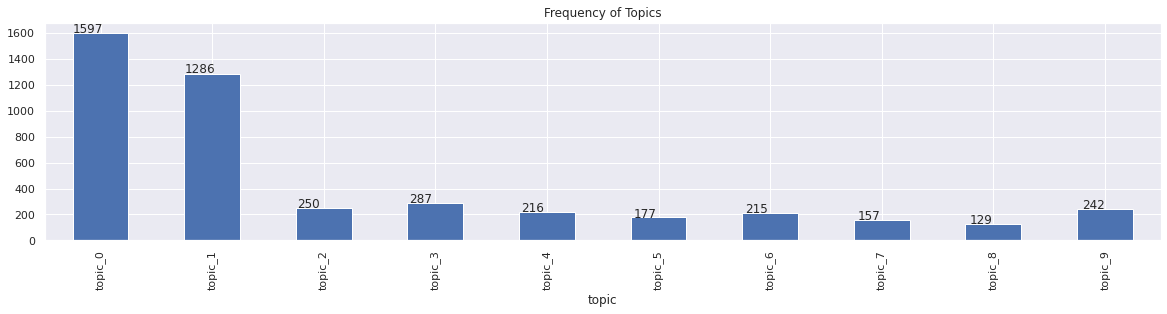

In [106]:
# Visualizing the single topic per description for understanding

plt.rcParams["figure.figsize"] = (20,4)

topic_frequency = df.iloc[:, :2].groupby('topic').count()
ax = topic_frequency.plot.bar( legend=False)
plt.title("Frequency of Topics", size=12)
# plt.xticks(rotation=45)
ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)


for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

In [107]:
topics_all = pd.DataFrame.from_dict(document_topic, orient='index')
topic_column_names = ['topic_' + str(i) for i in range(0, 10)]
topics_all.columns = topic_column_names
#topics_all.to_csv(os.path.join(BASE_PATH, "topic_propensities.csv"))

# print(topics_all.describe())
display(topics_all.head())

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.582345,0.011073,0.095518,0.007460,0.006418,0.005631,0.005017,0.004523,0.278236,0.003779
1,0.018853,0.121595,0.538508,0.009494,0.099076,0.007167,0.098590,0.096665,0.005241,0.004810
2,0.111025,0.106558,0.011334,0.104085,0.008168,0.102668,0.006385,0.005757,0.539209,0.004810
3,0.181718,0.445551,0.008906,0.007460,0.084332,0.005631,0.253981,0.004523,0.004118,0.003779
4,0.226700,0.481330,0.097509,0.008034,0.084227,0.083422,0.005403,0.004871,0.004435,0.004070


In [108]:
data_c = pd.concat([df_final2, topics_all], axis=1)
data_c = data_c[:-1]

In [154]:
df_matrix = data_c.drop(['Cast:missing'\
                          ],axis = 1)

In [179]:
data_c.shape

(5377, 233)

In [181]:
dat = data_c.drop('title',axis=1)

In [155]:
df_matrix = df_matrix.drop('title',axis=1).to_numpy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_matrix)
df_matrix=scaler.transform(df_matrix)

In [158]:
from sklearn.decomposition import PCA
pca = PCA().fit(df_matrix)
top_PCA=["%.2f" % a for a in pca.explained_variance_ratio_ if a >=0.001]
print(len(top_PCA))
print(top_PCA)
sumall=sum(pca.explained_variance_ratio_)

pca39 = PCA(n_components=len(top_PCA)).fit(df_matrix)
sum39=sum(pca39.explained_variance_ratio_)
print (sum39/sumall)

228
['0.02', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.

In [159]:
first_comp = pca39.components_[1]
first_comps = pd.DataFrame(list(zip(first_comp, df_final2.columns)), columns=['weights', 'features'])
first_comps['abs_weights']=first_comps['weights'].apply(lambda x: np.abs(x))
first_comps.sort_values('abs_weights', ascending=False,inplace=True)

Top_39_features=first_comps
Top_39_features

,weights,features,abs_weights
20,0.349224,genre:Sports Movies,0.349224
161,0.278597,meet,0.278597
197,0.218098,comedy,0.218098
155,0.216446,force,0.216446
72,0.208519,Cast:Sanjay Dutt,0.208519
...,...,...,...
98,-0.001311,Director:Ozan Açıktan,0.001311
118,-0.001023,Director:Steven Soderbergh,0.001023
89,0.000879,Director:Yılmaz Erdoğan,0.000879
158,0.000567,daughter,0.000567


### K MEANS

In [166]:
from sklearn.cluster import MiniBatchKMeans
Xpca=pca39.transform(df_matrix)
km=MiniBatchKMeans(n_clusters=13,init='k-means++',max_iter=500,n_init=1000,init_size=1000,batch_size=1000,
                  verbose=False)
km_model=km.fit(Xpca)
kmeanlabels=km.labels_
kmeanclusters = km.predict(Xpca)
kmeandistances = km.transform(Xpca)

In [167]:
films_kmeans = { 'title': list(data_c.title), 'rank': np.arange(0,len(data_c),1),'cluster': kmeanlabels}

frame_kmeans = pd.DataFrame(films_kmeans, index = [kmeanlabels] , columns = ['rank', 'title', 'cluster'])

frame_kmeans['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

8     2066
10    1230
5      853
7      433
1      333
4      276
2      131
0       19
11       8
9        8
3        7
12       7
6        6
Name: cluster, dtype: int64

In [175]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

#scaler = StandardScaler().fit(data_c)
#df_matrix=scaler.transform()

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(Xpca)
    kmeanModel.fit(Xpca)
 
    distortions.append(sum(np.min(cdist(Xpca, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / data_c.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(Xpca, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / data_c.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [173]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 1241182.4425608292
2 : 1226827.274588942
3 : 1214818.0181419025
4 : 1205914.2405876194
5 : 1195139.2075092075
6 : 1191656.6721450216
7 : 1184535.1350892936
8 : 1177345.4948542784
9 : 1167148.0345688183


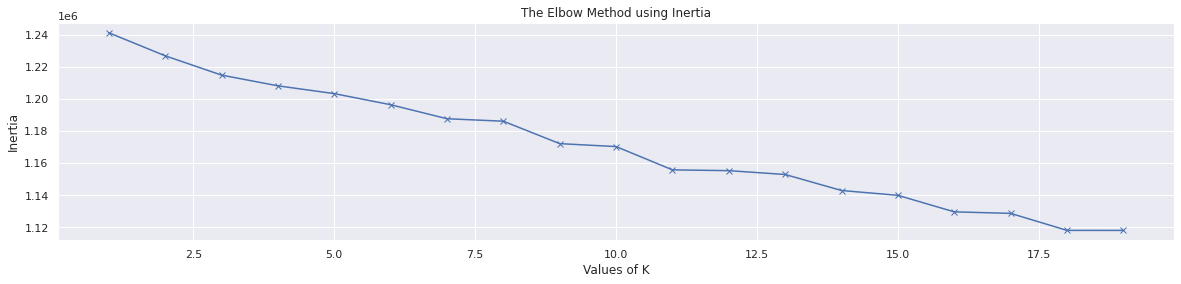

In [176]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

# Hiearchial Clustering

In [193]:
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as metrics

model = AgglomerativeClustering(n_clusters= 5, linkage = 'ward', affinity= 'euclidean')
cluster = model.fit_predict(dat).tolist()
dat["cluster"] = cluster

In [194]:
metrics.silhouette_score(dat, model.labels_)

0.43980379385069157

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Optimal number of clusters based on silhouette score: [5]


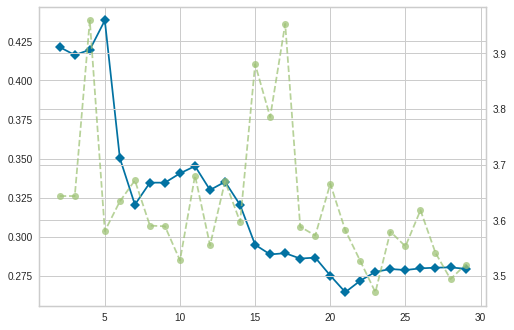

In [186]:
# Silhouette Score for Hierarchical Clustering

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), metric='silhouette', timings= True, locate_elbow=False)
visualizer.fit(dat)        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure

df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on silhouette score:', df4['centers'].tolist())

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as metrics
cluster_model = AgglomerativeClustering(n_clusters=5)  
cluster = cluster_model.fit_predict(dat).tolist()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz

Optimal number of clusters based on calinski_harabaz: [4]


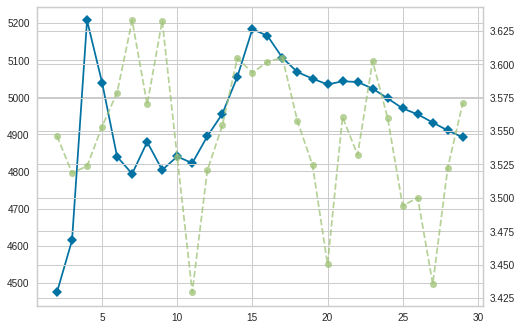

In [187]:
# Calinski Harabasz Score for Hierarchical Clustering

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric= 'calinski_harabaz', timings= True, locate_elbow=False)
visualizer.fit(dat)        # Fit the data to the visualizer
#visualizer.show()            # Finalize and render the figure

df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on calinski_harabaz:', df4['centers'].tolist())

Optimal number of clusters based on silhouette score: [3]


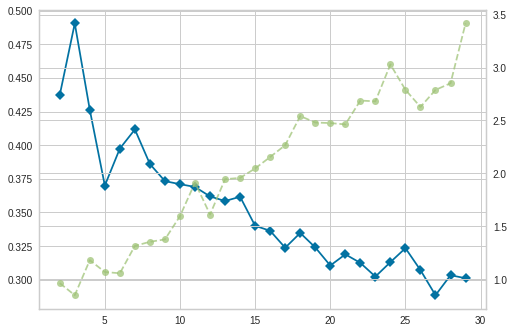

In [188]:
# Silhouette Score for Hierarchical Clustering

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), metric='silhouette', timings= True, locate_elbow=False)
visualizer.fit(dat)        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure

df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on silhouette score:', df4['centers'].tolist())

# **Cluster Analysis**

In [212]:
df_for_h_visual = df
df_for_h_visual["cluster"] = dat["cluster"]
#df_for_h_visual.drop(['propensity'], axis = 1, inplace=True)
df_for_h_visual.topic.fillna(value="Unknown", inplace=True)
df_for_h_visual.head()

,description,topic,propensity,cluster,title
0,After a devastating earthquake hits Mexico Cit...,topic_0,0.582345,1,7:19
1,"When an army recruit is found dead, his fellow...",topic_2,0.538508,1,23:59
2,"In a postapocalyptic world, rag-doll robots hi...",topic_8,0.539209,1,9
3,A brilliant group of students become card-coun...,topic_1,0.445551,0,21
4,"After an awful accident, a couple admitted to ...",topic_1,0.481330,1,122


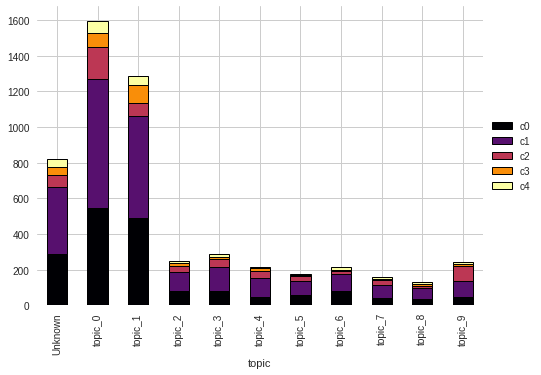

In [213]:
df_histo = df_for_h_visual.groupby(['topic','cluster']).count().reset_index()
df_histo = df_histo.pivot(index='topic', columns='cluster', values='description')
df_histo.columns = ["c0", "c1", "c2", "c3","c4"]

ax = df_histo.plot.bar(stacked=True,   colormap='inferno', edgecolor='black', linewidth=1)

ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

In [214]:
df_for_h_visual.groupby('cluster').count()

,description,topic,propensity,title
cluster,,,,
0,1794,1794,1504,1794
1,2411,2411,2035,2411
2,606,606,540,606
3,304,304,261,304
4,262,262,216,262


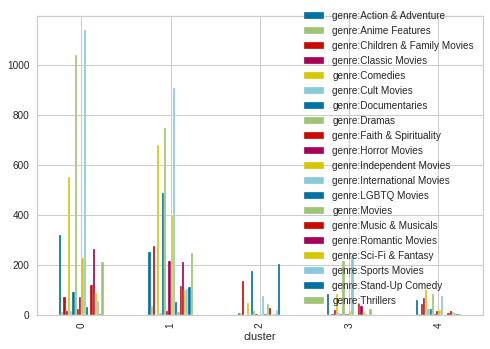

In [215]:
data_c = dat
data_c.head()
cols = [
'genre:Action & Adventure',
'genre:Anime Features',	
'genre:Children & Family Movies',	
'genre:Classic Movies',	
'genre:Comedies',	
'genre:Cult Movies',	
'genre:Documentaries',	
'genre:Dramas',	
'genre:Faith & Spirituality',	
'genre:Horror Movies',	
'genre:Independent Movies',	
'genre:International Movies',	
'genre:LGBTQ Movies',	
'genre:Movies',	
'genre:Music & Musicals',	
'genre:Romantic Movies',	
'genre:Sci-Fi & Fantasy',
'genre:Sports Movies',
'genre:Stand-Up Comedy',	
'genre:Thrillers',]

import pandas as pd
import matplotlib.pyplot as plt

df1 = data_c.groupby('cluster')[cols].sum().reset_index()
df1.plot(x="cluster", y= cols, kind="bar")

In [216]:
df_for_h_visual['title']= data_first['title']
documentaries_standup = df_for_h_visual.loc[df_for_h_visual['cluster'] == 2]
College_Friends_horror = df_for_h_visual.loc[df_for_h_visual['cluster'] == 3]
Survival_doc = df_for_h_visual.loc[df_for_h_visual['cluster'] == 1]
kids_animie_drama = df_for_h_visual.loc[df_for_h_visual['cluster'] == 4]# final
Attacks_politics_thriller= df_for_h_visual.loc[df_for_h_visual['cluster'] == 0]